## HIMAS Hyperparameter Tuning

This notebook executes Bayesian optimization for the ICU mortality prediction model using Google Colab's computational resources. The optimized hyperparameters and model weights are saved to Google Drive for integration with the local federated learning pipeline.

In [ ]:
!uv pip install keras-tuner google-cloud-bigquery db-dtypes pandas numpy scikit-learn tensorflow

Using Python 3.12.12 environment at: /usr
Resolved 62 packages in 342ms
Prepared 2 packages in 28ms
Installed 2 packages in 6ms
 + keras-tuner==1.4.7
 + kt-legacy==1.0.5


In [ ]:
# Import libraries
import os
import json
import logging
from datetime import datetime
from pathlib import Path
import numpy as np
import pandas as pd
from google.cloud import bigquery
from google.colab import auth, drive
import keras
from keras import layers
import keras_tuner as kt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [ ]:
# Authenticate with Google Cloud
logger.info("Authenticating with Google Cloud")
auth.authenticate_user()

INFO:root:Authenticating with Google Cloud
INFO:google.colab.auth:Failure refreshing credentials: ("Failed to retrieve http://metadata.google.internal/computeMetadata/v1/instance/service-accounts/default/?recursive=true from the Google Compute Engine metadata service. Status: 404 Response:\nb''", <google.auth.transport.requests._Response object at 0x7f3814827890>)
INFO:google.colab.auth:Failure refreshing credentials: ("Failed to retrieve http://metadata.google.internal/computeMetadata/v1/instance/service-accounts/default/?recursive=true from the Google Compute Engine metadata service. Status: 404 Response:\nb''", <google.auth.transport.requests._Response object at 0x7f38141764e0>)


In [ ]:
# Check GPU availability
import tensorflow as tf
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

print("="*70)
print("GPU CONFIGURATION CHECK")
print("="*70)

# Check TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

GPU CONFIGURATION CHECK
TensorFlow version: 2.19.0


In [ ]:
# Check GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU Available: {len(gpus)} device(s) detected")
    for gpu in gpus:
        print(f"  - {gpu}")

    # Configure GPU memory growth to prevent OOM errors
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logger.info("GPU memory growth enabled")
    except RuntimeError as e:
        logger.warning(f"Could not set memory growth: {e}")

    # Verify GPU is being used
    print(f"GPU devices visible to TensorFlow: {tf.config.list_logical_devices('GPU')}")
else:
    print("WARNING: No GPU detected!")
    print("  To enable GPU:")
    print("  1. Runtime → Change runtime type")
    print("  2. Hardware accelerator → GPU")
    print("  3. Save and restart")

print("="*70 + "\n")

INFO:__main__:GPU memory growth enabled


GPU Available: 1 device(s) detected
  - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
GPU devices visible to TensorFlow: [LogicalDevice(name='/device:GPU:0', device_type='GPU')]



In [ ]:
# Configuration Parameters
PROJECT_ID = "erudite-carving-472018-r5"
DATASET_ID = "federated"
TUNING_HOSPITAL = "hospital_c"  # Hospital to use for tuning

# Hyperparameter tuning settings
MAX_TRIALS = 25
EXECUTIONS_PER_TRIAL = 2

# GPU-optimized batch size (larger for GPU)
BATCH_SIZE = 64 if gpus else 32
EPOCHS = 100

# Output paths
DRIVE_OUTPUT_DIR = "/content/drive/MyDrive/The Grind Before The Shine/MLOps/HIMAS_Tuning_Results"
os.makedirs(DRIVE_OUTPUT_DIR, exist_ok=True)

# Feature definitions
NUMERICAL_FEATURES = [
    'age_at_admission', 'los_icu_hours', 'los_icu_days', 'los_hospital_days',
    'los_hospital_hours', 'n_distinct_icu_units', 'is_mixed_icu', 'n_icu_transfers',
    'n_total_transfers', 'ed_admission_flag', 'emergency_admission_flag',
    'hours_admit_to_icu', 'early_icu_score', 'weekend_admission', 'night_admission'
]

CATEGORICAL_FEATURES = [
    'icu_type', 'first_careunit', 'admission_type', 'admission_location',
    'insurance', 'gender', 'race', 'marital_status'
]

TARGET = 'icu_mortality_label'

logger.info(f"Configuration loaded - Project: {PROJECT_ID}, Dataset: {DATASET_ID}")
logger.info(f"Tuning on {TUNING_HOSPITAL} with {MAX_TRIALS} trials")

INFO:__main__:Configuration loaded - Project: erudite-carving-472018-r5, Dataset: federated
INFO:__main__:Tuning on hospital_c with 25 trials


In [ ]:
# Data Loading and Preprocessing
class DataPreprocessor:
    """Handles data preprocessing for HIMAS healthcare data."""

    def __init__(self):
        self.numerical_scaler = StandardScaler()
        self.label_encoders = {}
        self.is_fitted = False
        self.feature_dim = None

    def fit_transform(self, df):
        logger.info(f"Fitting preprocessor on {len(df)} samples")

        exclude_cols = [TARGET, 'stay_id', 'subject_id', 'hadm_id', 'icu_intime',
                       'icu_outtime', 'deathtime', 'death_date', 'assigned_hospital', 'data_split']
        X = df.drop(columns=[col for col in exclude_cols if col in df.columns])
        y = df[TARGET].values

        X_numerical = X[NUMERICAL_FEATURES].copy()
        for col in NUMERICAL_FEATURES:
            if col in X_numerical.columns:
                X_numerical[col] = pd.to_numeric(X_numerical[col], errors='coerce').astype('float64')
        X_numerical = X_numerical.fillna(X_numerical.median())
        X_numerical_scaled = self.numerical_scaler.fit_transform(X_numerical)

        X_categorical_encoded = []
        for col in CATEGORICAL_FEATURES:
            if col in X.columns:
                self.label_encoders[col] = LabelEncoder()
                col_data = X[col].fillna('Unknown').astype(str)
                encoded = self.label_encoders[col].fit_transform(col_data)
                X_categorical_encoded.append(encoded.reshape(-1, 1))

        if X_categorical_encoded:
            X_categorical_array = np.hstack(X_categorical_encoded)
            X_processed = np.hstack([X_numerical_scaled, X_categorical_array])
        else:
            X_processed = X_numerical_scaled

        self.is_fitted = True
        self.feature_dim = X_processed.shape[1]
        logger.info(f"Preprocessor fitted - Feature dimension: {self.feature_dim}")
        return X_processed, y

    def transform(self, df):
        if not self.is_fitted:
            raise ValueError("Preprocessor must be fitted first")

        exclude_cols = [TARGET, 'stay_id', 'subject_id', 'hadm_id', 'icu_intime',
                       'icu_outtime', 'deathtime', 'death_date', 'assigned_hospital', 'data_split']
        X = df.drop(columns=[col for col in exclude_cols if col in df.columns])
        y = df[TARGET].values

        X_numerical = X[NUMERICAL_FEATURES].copy()
        for col in NUMERICAL_FEATURES:
            if col in X_numerical.columns:
                X_numerical[col] = pd.to_numeric(X_numerical[col], errors='coerce').astype('float64')
        X_numerical = X_numerical.fillna(X_numerical.median())
        X_numerical_scaled = self.numerical_scaler.transform(X_numerical)

        X_categorical_encoded = []
        for col in CATEGORICAL_FEATURES:
            if col in X.columns and col in self.label_encoders:
                col_data = X[col].fillna('Unknown').astype(str)
                le = self.label_encoders[col]
                encoded = np.array([le.transform([val])[0] if val in le.classes_ else -1 for val in col_data])
                X_categorical_encoded.append(encoded.reshape(-1, 1))

        if X_categorical_encoded:
            X_categorical_array = np.hstack(X_categorical_encoded)
            X_processed = np.hstack([X_numerical_scaled, X_categorical_array])
        else:
            X_processed = X_numerical_scaled

        return X_processed, y


def load_hospital_data(hospital_name, split='train'):
    """Load data from BigQuery for specified hospital and split."""
    logger.info(f"Loading {split} data for {hospital_name}")

    client = bigquery.Client(project=PROJECT_ID)
    table_name = f"{hospital_name}_data"

    query = f"""
    SELECT *
    FROM `{PROJECT_ID}.{DATASET_ID}.{table_name}`
    WHERE data_split = '{split}'
    """

    df = client.query(query).to_dataframe()
    logger.info(f"Loaded {len(df)} samples, mortality rate: {df[TARGET].mean():.2%}")
    return df

In [ ]:
# Load training and validation data
logger.info("Loading training and validation data from BigQuery")

df_train = load_hospital_data(TUNING_HOSPITAL, 'train')
df_val = load_hospital_data(TUNING_HOSPITAL, 'validation')

# Preprocess data
preprocessor = DataPreprocessor()
X_train, y_train = preprocessor.fit_transform(df_train)
X_val, y_val = preprocessor.transform(df_val)

input_dim = preprocessor.feature_dim
logger.info(f"Data preprocessing complete - Input dimension: {input_dim}")

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
logger.info(f"Class weights: {class_weight_dict}")

INFO:__main__:Loading training and validation data from BigQuery
INFO:__main__:Loading train data for hospital_c
INFO:__main__:Loaded 14891 samples, mortality rate: 11.65%
INFO:__main__:Loading validation data for hospital_c
INFO:__main__:Loaded 3367 samples, mortality rate: 11.49%
INFO:__main__:Fitting preprocessor on 14891 samples
INFO:__main__:Preprocessor fitted - Feature dimension: 23
INFO:__main__:Data preprocessing complete - Input dimension: 23
INFO:__main__:Class weights: {0: np.float64(0.5659394952873213), 1: np.float64(4.29135446685879)}


In [ ]:
# Set random seeds for reproducibility
import random

RANDOM_SEED = 42

def set_seed(seed=42):
    """Set random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    tf.config.experimental.enable_op_determinism()

set_seed(RANDOM_SEED)
logger.info(f"Random seed set to {RANDOM_SEED}")

In [ ]:
# Model Builder for Hyperparameter Tuning
def build_tunable_model(hp):
    """Build model with tunable hyperparameters - GPU optimized."""

    with tf.device('/GPU:0' if gpus else '/CPU:0'):
        num_layers = hp.Int('num_layers', 2, 5, 1)
        architecture = hp.Choice('architecture', ['decreasing', 'uniform', 'bottleneck'])
        first_layer_units = hp.Int('first_layer_units', 64, 512, 64)
        activation = hp.Choice('activation', ['relu', 'elu', 'selu'])
        dropout_rate = hp.Float('dropout_rate', 0.1, 0.5, 0.1)
        l2_strength = hp.Float('l2_strength', 1e-5, 1e-2, sampling='log')
        learning_rate = hp.Float('learning_rate', 1e-5, 1e-2, sampling='log')
        optimizer_choice = hp.Choice('optimizer', ['adam', 'adamw', 'rmsprop'])

        model = keras.Sequential([keras.Input(shape=(input_dim,))])

        if architecture == 'decreasing':
            units = first_layer_units
            for _ in range(num_layers):
                model.add(layers.Dense(units, activation=activation,
                                      kernel_regularizer=keras.regularizers.l2(l2_strength)))
                model.add(layers.BatchNormalization())
                model.add(layers.Dropout(dropout_rate))
                units = max(32, units // 2)
        elif architecture == 'uniform':
            for _ in range(num_layers):
                model.add(layers.Dense(first_layer_units, activation=activation,
                                      kernel_regularizer=keras.regularizers.l2(l2_strength)))
                model.add(layers.BatchNormalization())
                model.add(layers.Dropout(dropout_rate))
        else:
            units_sequence = [max(32, first_layer_units // (2 ** i) if i < num_layers // 2
                                 else first_layer_units // (2 ** (num_layers - i - 1)))
                             for i in range(num_layers)]
            for units in units_sequence:
                model.add(layers.Dense(units, activation=activation,
                                      kernel_regularizer=keras.regularizers.l2(l2_strength)))
                model.add(layers.BatchNormalization())
                model.add(layers.Dropout(dropout_rate))

        model.add(layers.Dense(1, activation='sigmoid'))

        optimizer = {'adam': keras.optimizers.Adam, 'adamw': keras.optimizers.AdamW,
                    'rmsprop': keras.optimizers.RMSprop}[optimizer_choice](learning_rate=learning_rate)

        model.compile(optimizer=optimizer, loss='binary_crossentropy',
                     metrics=['accuracy', keras.metrics.AUC(name='auc'),
                             keras.metrics.Precision(name='precision'), keras.metrics.Recall(name='recall')])

    return model

In [ ]:
# Verify GPU usage before starting
if gpus:
    print("\n" + "="*70)
    print("GPU ACCELERATION ENABLED")
    print("="*70)
    print(f"Training will utilize GPU: {gpus[0].name}")
    print(f"Batch size optimized for GPU: {BATCH_SIZE}")
    print("="*70 + "\n")
else:
    print("\nWARNING: Running on CPU - Consider enabling GPU for faster training\n")


GPU ACCELERATION ENABLED
Training will utilize GPU: /physical_device:GPU:0
Batch size optimized for GPU: 64



In [ ]:
# Initialize Bayesian Optimization Tuner
logger.info("Initializing Bayesian optimization tuner")
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

tuner = kt.BayesianOptimization(
    build_tunable_model,
    objective=kt.Objective('val_auc', direction='max'),
    max_trials=MAX_TRIALS,
    executions_per_trial=EXECUTIONS_PER_TRIAL,
    directory='/content/tuner_output',
    project_name='himas_mortality_prediction'
)

logger.info(f"Starting hyperparameter search with {MAX_TRIALS} trials")

# Configure callbacks
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_auc', patience=10, mode='max', restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
]

# Execute search
start_time = datetime.now()
logger.info(f"Search started at {start_time.strftime('%Y-%m-%d %H:%M:%S')}")

tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

end_time = datetime.now()
duration = (end_time - start_time).total_seconds() / 3600

logger.info(f"Search completed in {duration:.2f} hours")

INFO:__main__:Search completed in 0.85 hours


Trial 25 Complete [00h 01m 39s]
val_auc: 0.9037293791770935

Best val_auc So Far: 0.925400584936142
Total elapsed time: 00h 51m 12s


In [ ]:
logger.info("Extracting best trial results")

best_hps = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.get_best_models(1)[0]
best_trial = tuner.oracle.get_best_trials(1)[0]

best_val_auc = float(best_trial.metrics.get_best_value('val_auc'))
best_val_acc = float(best_trial.metrics.get_best_value('val_accuracy'))

print("\n" + "="*70)
print("BEST HYPERPARAMETERS")
print("="*70)
for param, value in best_hps.values.items():
    print(f"  {param}: {value}")
print("="*70)
print(f"Best Validation AUC: {best_val_auc:.4f}")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print("="*70 + "\n")

INFO:__main__:Extracting best trial results



BEST HYPERPARAMETERS
  num_layers: 3
  architecture: decreasing
  first_layer_units: 320
  activation: selu
  dropout_rate: 0.2
  l2_strength: 0.00017879831499230929
  learning_rate: 0.004824014039833979
  optimizer: adamw
Best Validation AUC: 0.9254
Best Validation Accuracy: 0.9012



/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Save all results to Google Drive
logger.info("Saving results to Google Drive")

# Hyperparameters JSON
hp_filename = f"{TUNING_HOSPITAL}_best_hyperparameters_{timestamp}.json"
hp_path = os.path.join(DRIVE_OUTPUT_DIR, hp_filename)
with open(hp_path, 'w') as f:
    json.dump(best_hps.values, f, indent=2)
logger.info(f"Hyperparameters saved: {hp_filename}")

# Best model
model_filename = f"{TUNING_HOSPITAL}_best_model_{timestamp}.keras"
model_path = os.path.join(DRIVE_OUTPUT_DIR, model_filename)
best_model.save(model_path)
logger.info(f"Model saved: {model_filename}")

# Model weights only
weights_filename = f"{TUNING_HOSPITAL}_best_model_weights_{timestamp}.weights.h5"
weights_path = os.path.join(DRIVE_OUTPUT_DIR, weights_filename)
best_model.save_weights(weights_path)
logger.info(f"Weights saved: {weights_filename}")

# Top trials
top_trials = tuner.oracle.get_best_trials(num_trials=min(10, MAX_TRIALS))
trial_results = [{
    'rank': idx + 1,
    'trial_id': trial.trial_id,
    'val_auc': float(trial.metrics.get_best_value('val_auc')),
    'val_accuracy': float(trial.metrics.get_best_value('val_accuracy')),
    **trial.hyperparameters.values
} for idx, trial in enumerate(top_trials)]

trials_filename = f"{TUNING_HOSPITAL}_top_trials_{timestamp}.json"
trials_path = os.path.join(DRIVE_OUTPUT_DIR, trials_filename)
with open(trials_path, 'w') as f:
    json.dump(trial_results, f, indent=2)
logger.info(f"Trial results saved: {trials_filename}")

INFO:__main__:Saving results to Google Drive
INFO:__main__:Hyperparameters saved: hospital_c_best_hyperparameters_20251109_035429.json
INFO:__main__:Model saved: hospital_c_best_model_20251109_035429.keras
INFO:__main__:Weights saved: hospital_c_best_model_weights_20251109_035429.weights.h5
INFO:__main__:Trial results saved: hospital_c_top_trials_20251109_035429.json


In [ ]:
# Summary
summary = {
    'timestamp': timestamp,
    'execution_time_hours': duration,
    'gpu_used': len(gpus) > 0,
    'gpu_name': gpus[0].name if gpus else None,
    'hospital': TUNING_HOSPITAL,
    'project_id': PROJECT_ID,
    'dataset_id': DATASET_ID,
    'max_trials': MAX_TRIALS,
    'executions_per_trial': EXECUTIONS_PER_TRIAL,
    'batch_size': BATCH_SIZE,
    'training_samples': len(X_train),
    'validation_samples': len(X_val),
    'input_dimension': input_dim,
    'best_hyperparameters': best_hps.values,
    'best_val_auc': best_val_auc,
    'best_val_accuracy': best_val_acc,
    'files': {
        'hyperparameters': hp_filename,
        'model': model_filename,
        'weights': weights_filename,
        'trials': trials_filename
    }
}

summary_filename = f"{TUNING_HOSPITAL}_tuning_summary_{timestamp}.json"
summary_path = os.path.join(DRIVE_OUTPUT_DIR, summary_filename)
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)
logger.info(f"Summary saved: {summary_filename}")

INFO:__main__:Summary saved: hospital_c_tuning_summary_20251109_035429.json


INFO:__main__:Generating visualizations
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


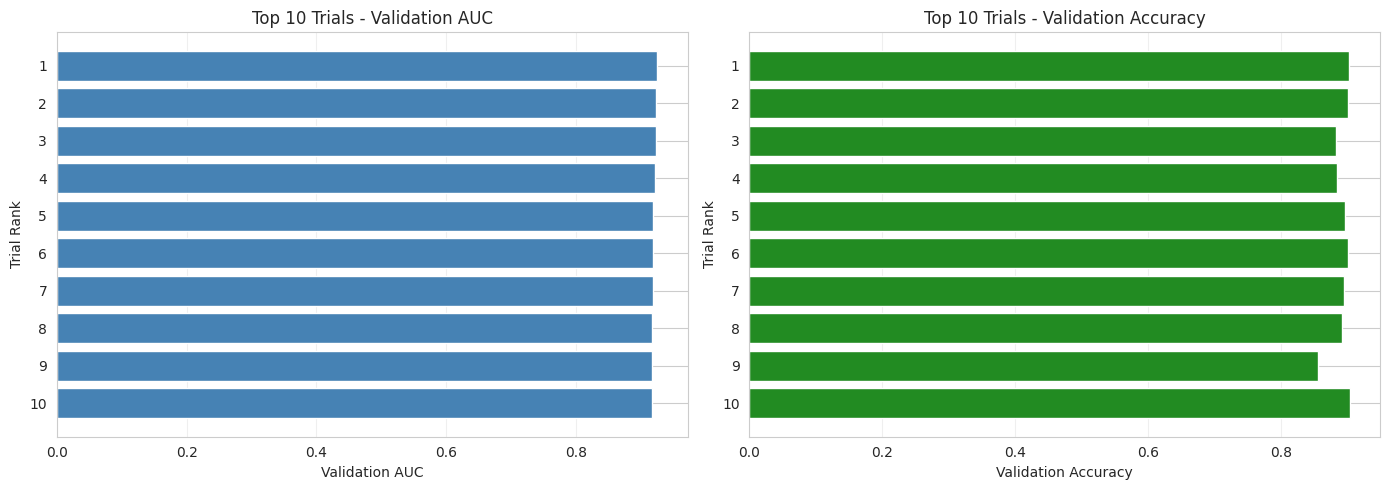

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
logger.info("Generating visualizations")

df_trials = pd.DataFrame(trial_results)

# Top trials comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].barh(df_trials['rank'].astype(str), df_trials['val_auc'], color='steelblue')
axes[0].set_xlabel('Validation AUC')
axes[0].set_ylabel('Trial Rank')
axes[0].set_title('Top 10 Trials - Validation AUC')
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

axes[1].barh(df_trials['rank'].astype(str), df_trials['val_accuracy'], color='forestgreen')
axes[1].set_xlabel('Validation Accuracy')
axes[1].set_ylabel('Trial Rank')
axes[1].set_title('Top 10 Trials - Validation Accuracy')
axes[1].invert_yaxis()
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(os.path.join(DRIVE_OUTPUT_DIR, f'{TUNING_HOSPITAL}_top_trials_{timestamp}.png'), dpi=300)
plt.show()

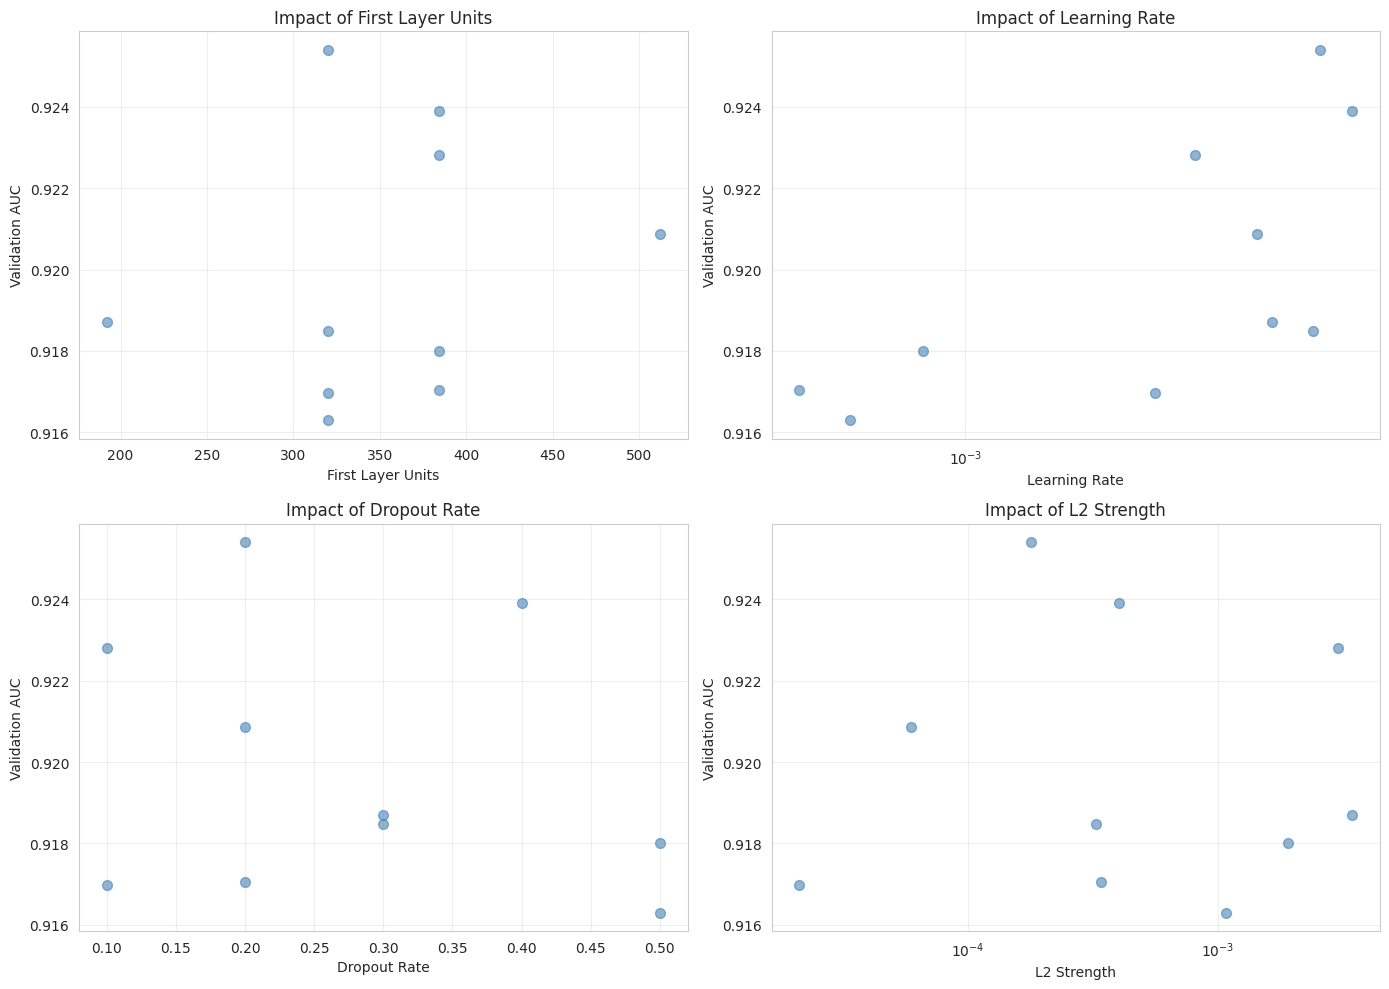

INFO:__main__:Visualizations saved


In [ ]:
# Hyperparameter impact
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

continuous_params = ['first_layer_units', 'learning_rate', 'dropout_rate', 'l2_strength']

for idx, param in enumerate(continuous_params):
    if param in df_trials.columns:
        axes[idx].scatter(df_trials[param], df_trials['val_auc'], alpha=0.6, s=50, color='steelblue')
        axes[idx].set_xlabel(param.replace('_', ' ').title())
        axes[idx].set_ylabel('Validation AUC')
        axes[idx].set_title(f'Impact of {param.replace("_", " ").title()}')
        axes[idx].grid(True, alpha=0.3)
        if param in ['learning_rate', 'l2_strength']:
            axes[idx].set_xscale('log')

plt.tight_layout()
plt.savefig(os.path.join(DRIVE_OUTPUT_DIR, f'{TUNING_HOSPITAL}_hyperparameter_impact_{timestamp}.png'), dpi=300)
plt.show()

logger.info("Visualizations saved")